<div style="display:flex">
    <img src="https://bse.eu/sites/default/files/bse_logo_small.png" alt="Logo 1">
</div>

# Error Analysis

### Environment Setup and Imports

In [1]:
# Importing Libraries
import os
import cv2
import glob
import torch
import shutil
import random
import pathlib
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_theme(style='darkgrid')
import matplotlib.pyplot as plt

from PIL import Image
from IPython.display import Video

from tqdm.notebook import trange, tqdm

import yaml
from ultralytics import YOLO

import warnings
warnings.filterwarnings('ignore')

# Setting the random seed for reproducibility
random.seed(42)
np.random.seed(42)

In [ ]:
class_names = {'0': 'Green Light', '1': 'Red Light', '2': 'Speed Limit 10',   '3': 'Speed Limit 100', '4': 'Speed Limit 110', '5': 'Speed Limit 120', '6': 'Speed Limit 20', '7': 'Speed Limit 30', '8': 'Speed Limit 40', '9': 'Speed Limit 50', '10': 'Speed Limit 60', '11': 'Speed Limit 70', '12': 'Speed Limit 80', '13': 'Speed Limit 90', '14': 'Stop'}

# define a updated class names where we skip speed limit 10
class_names_updated = { '0': 'Green Light', '1': 'Red Light', '2': 'Speed Limit 100', '3': 'Speed Limit 110', '4': 'Speed Limit 120', '5': 'Speed Limit 20', '6': 'Speed Limit 30', '7': 'Speed Limit 40', '8': 'Speed Limit 50', '9': 'Speed Limit 60', '10': 'Speed Limit 70', '11': 'Speed Limit 80', '12': 'Speed Limit 90', '13': 'Stop'}

### Helper Functions

In [4]:
def display_images(post_training_files_path, image_files):
    for image_file in image_files:
        image_path = os.path.join(post_training_files_path, image_file)
        img = cv2.imread(image_path)

        if img is None or (img == 255).all():
            print(f"[ERROR] Image not found or blank (all white): {image_path}")
            continue

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.figure(figsize=(10, 10), dpi=120)
        plt.imshow(img)
        plt.axis('off')
        plt.title(image_file)
        plt.tight_layout()
        plt.show()

Below we design a function to visually inspect the predictions (both correct and failed of any model on our test set). This function allows to see the entire test set predictions in orderd batches of 9 images, desgined to be able ot move to the next and previous batch smoothly, and easilly transition to any given batch at any point. 

In [59]:
class TestSetVisualizer:
    def __init__(self, model, images_dir=None, batch_size=9, img_size=(640, 640)):
        """
        model        : a loaded YOLO model, e.g. YOLO 
        images_dir   : path to your test images folder (default: ./data/test/images)
        batch_size   : how many images per page (must be a perfect square)
        img_size     : (w,h) size to resize for prediction
        """
        self.model = model
        self.batch_size = batch_size
        self.img_size = img_size

        # default images folder
        if images_dir is None:
            base = os.getcwd()
            images_dir = os.path.join(base, 'data', 'test', 'images')

        # gather image filenames
        self.images = sorted([
            f for f in os.listdir(images_dir)
            if f.lower().endswith(('.jpg', '.png', '.jpeg'))
        ])
        self.images_dir = images_dir

        # compute number of pages
        self.num_pages = int(np.ceil(len(self.images) / batch_size))
        self.page = 0  # current page index

        # derive grid dims (e.g. 3×3 for batch_size=9)
        sq = int(np.sqrt(batch_size))
        if sq * sq != batch_size:
            raise ValueError("batch_size must be a perfect square (e.g. 4,9,16)")
        self.grid_shape = (sq, sq)

    def show_page(self, page=None, conf=0.25):
        """
        Render one “page” (batch) of images.
        page: int index in [0..num_pages-1]. If None, uses self.page.
        """
        if page is None:
            page = self.page
        # clamp
        page = max(0, min(self.num_pages - 1, page))
        self.page = page

        start = page * self.batch_size
        end   = start + self.batch_size
        batch = self.images[start:end]

        rows, cols = self.grid_shape
        fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 4*rows))
        fig.suptitle(f"Test Set Inferences — Page {page+1}/{self.num_pages}", fontsize=16)

        for i, ax in enumerate(axes.flatten()):
            if i < len(batch):
                img_name = batch[i]
                img_path = os.path.join(self.images_dir, img_name)

                img = cv2.imread(img_path)
                if img is None:
                    ax.set_title(f"failed: {img_name}")
                    ax.axis('off')
                else:
                    img = cv2.resize(img, self.img_size)
                    results = self.model.predict(source=img, imgsz=self.img_size, conf=conf)
                    ann = results[0].plot(line_width=2)
                    ann = cv2.cvtColor(ann, cv2.COLOR_BGR2RGB)
                    ax.imshow(ann)
                    ax.set_title(img_name, fontsize=8)
                    ax.axis('off')
            else:
                ax.axis('off')

        plt.tight_layout()
        plt.show()

    def next(self, conf=0.5):
        """Advance one page forward (wraps around)."""
        self.page = (self.page + 1) % self.num_pages
        self.show_page(self.page, conf=conf)

    def prev(self, conf=0.5):
        """Go one page backward (wraps around)."""
        self.page = (self.page - 1) % self.num_pages
        self.show_page(self.page, conf=conf)

    def goto(self, page, conf=0.5):
        """Jump to a specific page (0-indexed)."""
        self.show_page(page, conf=conf)

FInally, we also design a function to generate a dataframe that contains our most important analytical metrics, out of the evaluation object that the ultralitics package provides

In [25]:
def compute_f1(precision: float, recall: float) -> float:
    """
    Compute the F1 score from precision and recall.
    Returns 0.0 if both precision and recall are zero.
    """
    if precision + recall > 0:
        return 2 * (precision * recall) / (precision + recall)
    return 0.0

def metrics_to_dataframe(metrics, class_names: dict) -> pd.DataFrame:
    """
    Convert a YOLOv8 metrics object into a pandas DataFrame
    with per-class Precision, Recall, F1, AP@0.50, and AP@0.50-0.95.
    
    Parameters:
    - metrics: the object returned by model.val(...)
    - class_names: dict mapping string class indices to class names
    
    Returns:
    - DataFrame with columns ['Class Name','Precision','Recall','F1','AP@0.50','AP@0.50:0.95']
    """
    metrics_list = []
    num_classes = metrics.box.maps.shape[0]

    for i in range(num_classes-1):
        p, r, ap50, ap5095 = metrics.box.class_result(i)
        f1 = compute_f1(p, r)
        metrics_list.append({
            'Class Name': class_names[str(i)],
            'Precision': round(p, 3),
            'Recall': round(r, 3),
            'F1': round(f1, 3),
            'AP@0.50': round(ap50, 3),
            'AP@0.50:0.95': round(ap5095, 3)
        })

    return pd.DataFrame(metrics_list)

## Few-shot: 6% of the Dataset


### Training Evolution

In [14]:
results_training_fewshot = pd.read_csv(os.path.join((os.getcwd()),"runs","detect","few_shot_training_1","results.csv"))
results_training_fewshot.tail(10)

epoch     time  train/box_loss  train/cls_loss  train/dfl_loss  \
15     16  305.543         0.56052         2.45488         0.96379   
16     17  323.136         0.58039         2.33059         0.98702   
17     18  341.624         0.56977         2.28453         1.03074   
18     19  360.161         0.55677         2.24246         1.00153   
19     20  378.530         0.56153         2.18123         0.93308   
20     21  396.097         0.52210         2.06499         0.92980   
21     22  413.481         0.51021         2.00598         0.92047   
22     23  431.232         0.51829         1.91642         0.92124   
23     24  449.025         0.58706         2.06525         0.96606   
24     25  467.772         0.49728         2.08436         0.93374   

    metrics/precision(B)  metrics/recall(B)  metrics/mAP50(B)  \
15               0.45487            0.47070           0.45290   
16               0.47391            0.48638           0.48384   
17               0.49102            0.51608           0.49875   
18               0.50736            0.51822           0.51278   
19               0.54008            0.47663           0.51819   
20               0.54751            0.48684           0.53246   
21               0.61104            0.48701           0.55054   
22               0.61285            0.50636           0.56016   
23               0.59939            0.51879           0.56372   
24               0.62452            0.49334           0.56562   

    metrics/mAP50-95(B)  val/box_loss  val/cls_loss  val/dfl_loss    lr/pg0  \
15              0.37562       0.74326       1.76804       1.09419  0.000214   
16              0.40252       0.74742       1.68242       1.09805  0.000193   
17              0.41796       0.74231       1.62477       1.09638  0.000172   
18              0.43027       0.72902       1.60995       1.07781  0.000151   
19              0.43509       0.72773       1.63146       1.07199  0.000130   
20              0.44924       0.72908       1.59222       1.07177  0.000109   
21              0.46835       0.71913       1.55554       1.06230  0.000089   
22              0.47700       0.71533       1.52277       1.06255  0.000068   
23              0.48078       0.71501       1.50824       1.06176  0.000047   
24              0.48166       0.71352       1.50193       1.06062  0.000026   

      lr/pg1    lr/pg2  
15  0.000214  0.000214  
16  0.000193  0.000193  
17  0.000172  0.000172  
18  0.000151  0.000151  
19  0.000130  0.000130  
20  0.000109  0.000109  
21  0.000089  0.000089  
22  0.000068  0.000068  
23  0.000047  0.000047  
24  0.000026  0.000026

### Run Evaluation

In [9]:
# Loading the best performing model
Valid_model = YOLO(os.path.join((os.getcwd()),"runs","detect","few_shot_training_1","weights","best.pt"))

# Evaluating the model on the validset
metrics = Valid_model.val(data = 'data/few_shot_data.yaml',
                        name='few_shot_best_model',
                        split='val')

Ultralytics 8.3.155  Python-3.11.12 torch-2.7.1+cpu CPU (Intel Core(TM) i7-10510U 1.80GHz)
Model summary (fused): 72 layers, 3,008,573 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.30.1 ms, read: 23.611.0 MB/s, size: 15.8 KB)


val: Scanning C:\Users\amalo\Desktop\MASTER\3rd_TERM\Applications_of_Deep_Learning\TermPoster\data\valid\labels.cache... 801 images, 0 backgrounds, 0 corrupt: 100%|██████████| 801/801 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [01:53<00:00,  2.22s/it]


                   all        801        944      0.624      0.494      0.566      0.482
           Green Light         87        122      0.663      0.287      0.401       0.24
             Red Light         74        108      0.776      0.354      0.473      0.271
       Speed Limit 100         52         52      0.465      0.404      0.448      0.412
       Speed Limit 110         17         17      0.316      0.235       0.27      0.244
       Speed Limit 120         60         60      0.695       0.65      0.687      0.611
        Speed Limit 20         56         56      0.648      0.786      0.803      0.671
        Speed Limit 30         71         74      0.516      0.473      0.484      0.442
        Speed Limit 40         53         55      0.619      0.582      0.648      0.551
        Speed Limit 50         68         71       0.77      0.493      0.691      0.609
        Speed Limit 60         76         76      0.709      0.658      0.742      0.664
        Speed Limit 7

### Analytical Evaluation: Recall, Precision and AP

When visualizing the performance of the models, our most relevant metrics are Precision, Recall and AP. 

- AP (Average Precision) measures the area under de Precision-Recall curve for a single class, at a specific IoU threshold (eg. 0.5). Essentially, it's a **weighted Precision across all different Recall values**, that captures how well each model performs for the specific class across confidence threhsolds. 

- **mAP is the average of all APs** across all classes that we have. `mAP@50` averages all APs at IoU= 0.5 (an overlap of 50% between our predicted box and the ground truth containg the specific object we are trying to detect), while it is also common to look at `mAP@50-95`, which averages all mAP for IoU thresholds between 0.5 and 0.95. 

`mAP@50` measures a more loose object detection, while `mAP@50-95` is stricter and more robust, penalizing more poor box fitting. Therefore, `map@50` is more easy to optimize and to compare as a basleine, while a real life model would prioritize `mAP@50-95`. 

In [28]:
# Load the metrics using our helper function
metrics_df= metrics_to_dataframe(metrics, class_names_updated)

# Save the metrics to a CSV file
metrics_df.to_csv(os.path.join((os.getcwd()),"runs","detect","few_shot_best_model","metrics_per_class.csv"), index=False)

In [29]:
metrics_df.head(14)

Class Name  Precision  Recall     F1  AP@0.50  AP@0.50:0.95
0       Green Light      0.663   0.287  0.400    0.401         0.240
1         Red Light      0.776   0.354  0.486    0.473         0.271
2   Speed Limit 100      0.465   0.404  0.432    0.448         0.412
3   Speed Limit 110      0.316   0.235  0.270    0.270         0.244
4   Speed Limit 120      0.695   0.650  0.672    0.687         0.611
5    Speed Limit 20      0.648   0.786  0.710    0.803         0.671
6    Speed Limit 30      0.516   0.473  0.493    0.484         0.442
7    Speed Limit 40      0.619   0.582  0.600    0.648         0.551
8    Speed Limit 50      0.770   0.493  0.601    0.691         0.609
9    Speed Limit 60      0.709   0.658  0.683    0.742         0.664
10   Speed Limit 70      0.813   0.628  0.709    0.764         0.683
11   Speed Limit 80      0.468   0.393  0.427    0.456         0.388
12   Speed Limit 90      0.330   0.211  0.257    0.215         0.191
13             Stop      0.953   0.765  0.849    0.843         0.769

Looking at the results, the first thing we notice is that the largest gap between Precision and Recall goes for both traffic lights. Despite being the most common class, and that with the highest number or few-shot training examples, it is almost the worst performing in terms of F1 score. This seems to be rather strange given that these two classes are supposedly easy to discern (given that they have pretty unique colors). The only reason we could straightforwardly think of is that the model perhaps has seen images from far where the colors are not as distinctive. 

The actual worst performing class is `Speed Limit 90`, which shows very bad results on both Precision and Recall. There is no apparent reason why this could happen, so perhaps the training signal was noisy for this specific class. The following error analysis techniques will allow us to gain better insights into the problem

`Speed Limit 110`, our rarest class, also shows very bad results. This suggests that, in general, the model needs very little examples to learn as there are clear differences between a class with 4 examples in training (`Speed Limit 110`), and others with a few more. This hypothesis can be tested later using the models trained with higher percentages of data. 

The best results (by far) are achieved by the `Stop` signal, which achieves an outstanding Precision of 95%. However, a significant drop in Recall (77%) suggests that we are still underpredicting this class and thus results could be further improved. 

Despite a good F1 (relative to the other classes), `Speed Limit 50` presents an unsusually high difference between precision and Recall, also suggesting that the model underpredicts safely, given that a low recall means we are missing out on predicting many true positives. 



Therefore, the visual analysis of predictions will focus on these three rather unexpected classes: `Green Light`, `Red Light`,  `Speed Limit 50` and `Speed Limit 90`. 

Before doing so, let's look at a few more performance evaluators to gain a deeper insight into the results

### Precision-Recall Curve

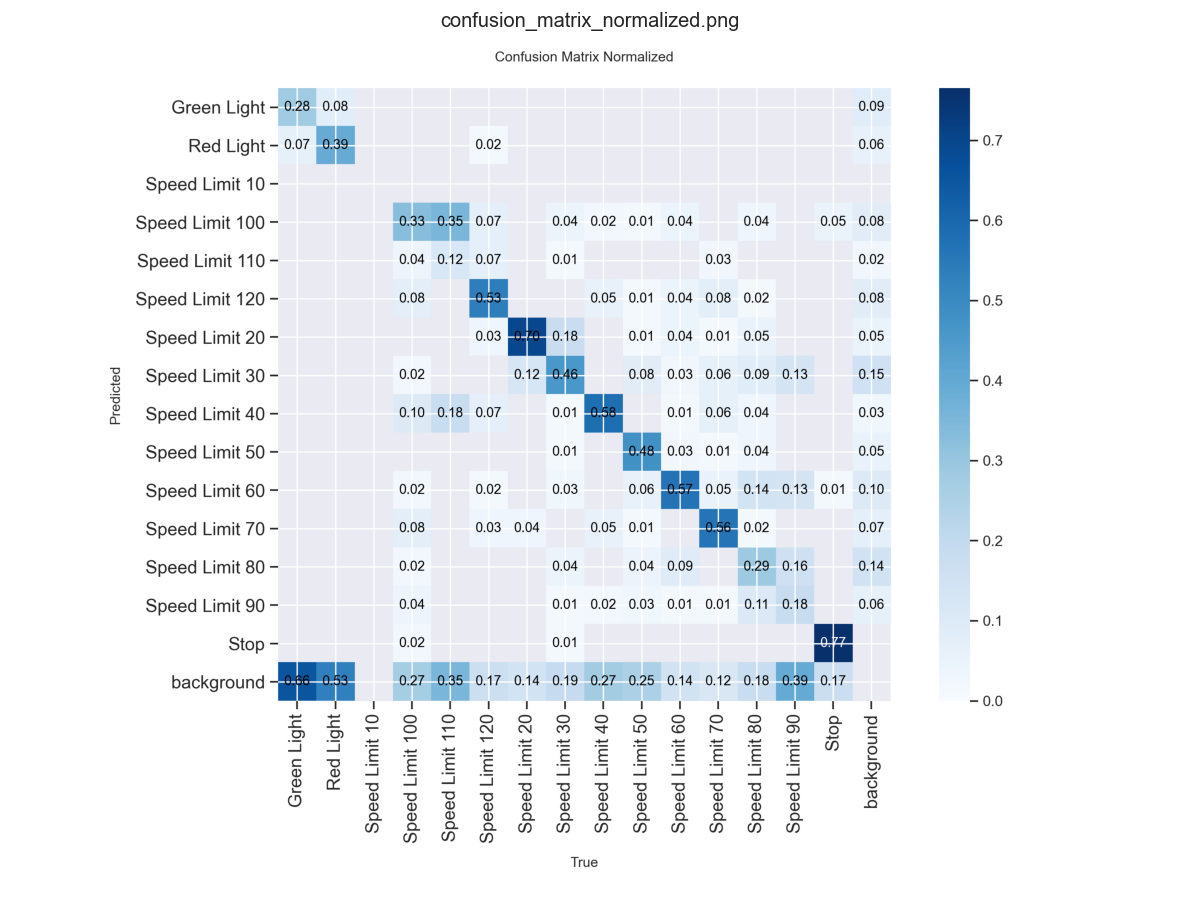

In [30]:
evaluation_files_path = os.path.join((os.getcwd()),"runs","detect","few_shot_best_model")

image_files = ['confusion_matrix_normalized.png'
               ]

# Display the images
display_images(evaluation_files_path, image_files)

Results from the Confusion Matrix confirm some of the Hypothesis from the initial interpreation of results. 

One interesting thing we notice is that most of the prediction errors for the speed limit signals are coming from its closest neighbours (in terms of speed limit). For instance, `Speed Limit 100` gets very often confused with `Speed Limit 110`. In general, the highest confusion always comes from the immediate neighbour. 

The traffic signs sometimes get confused between each other, but never with speed signals. This suggests that the model has already learned to differentiate them from the other classes, yet still does not pick up on many examples. The last row also tells us that most of the false negatives don't come from erroneous predictions, but rather from missing out on them. Perhaps lowering the confidence threshold would improve results (see following plot). In contrast, the last column demonstrates that the model rarely hallucinates and predicts traffic signs for background. 

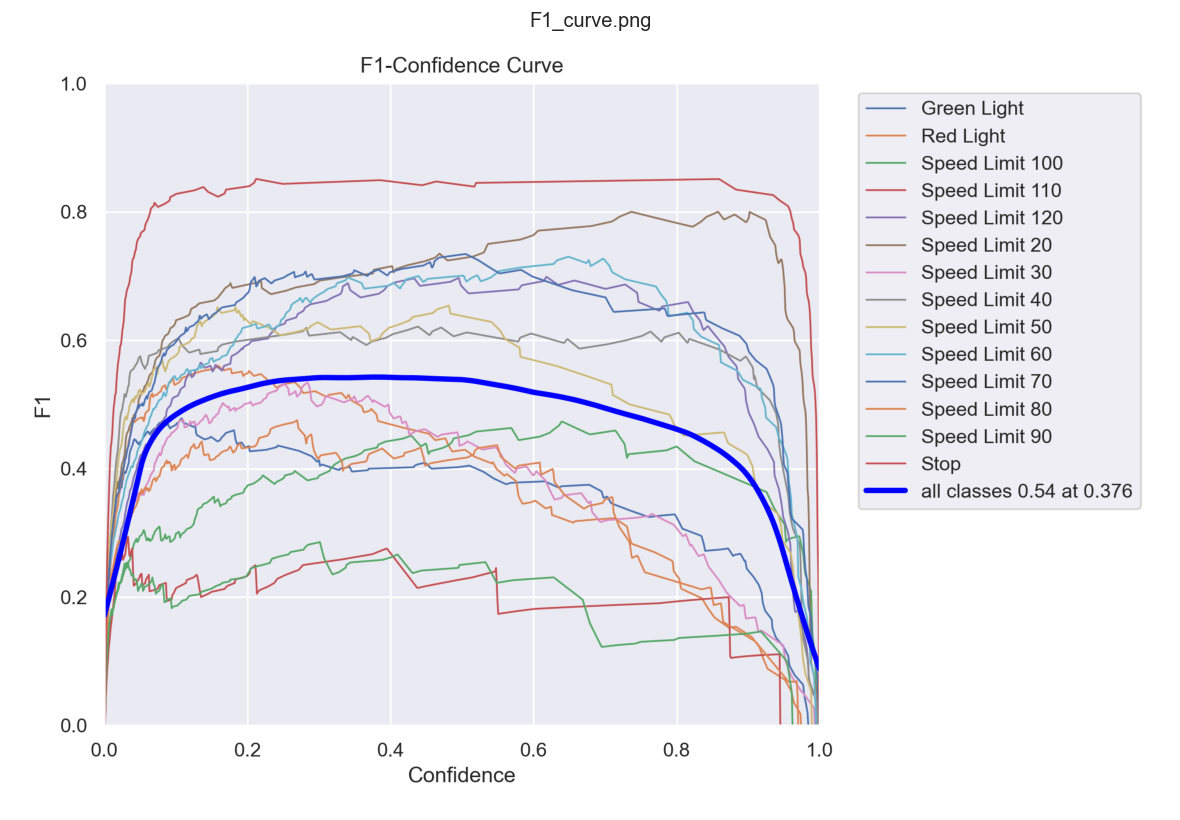

In [33]:
display_images(evaluation_files_path, ['F1_curve.png'])

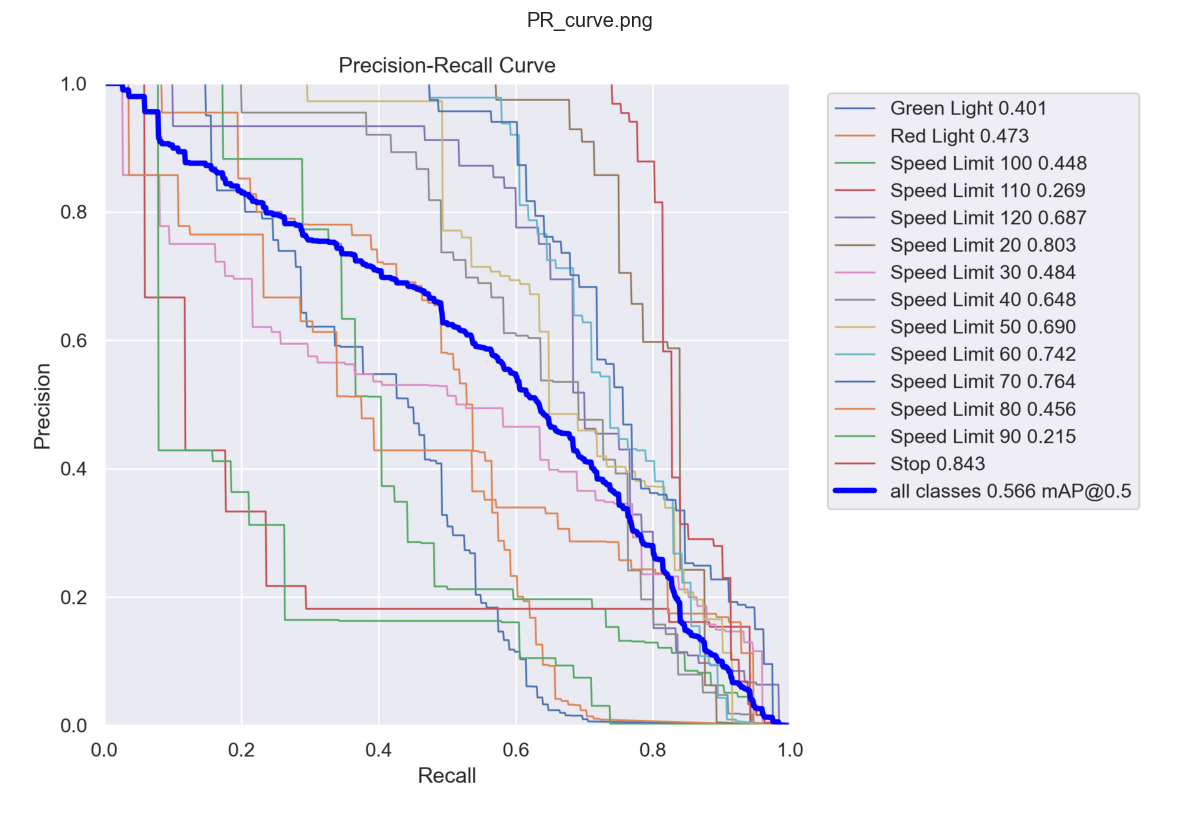

In [32]:
display_images(evaluation_files_path, ['PR_curve.png'])

### Visual Inspection


0: 640x640 1 Speed Limit 30, 102.9ms
Speed: 3.0ms preprocess, 102.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Speed Limit 60, 90.0ms
Speed: 2.8ms preprocess, 90.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Speed Limit 20, 90.1ms
Speed: 3.3ms preprocess, 90.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Speed Limit 20, 96.5ms
Speed: 5.0ms preprocess, 96.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Speed Limit 20, 98.7ms
Speed: 3.6ms preprocess, 98.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Speed Limit 20, 90.6ms
Speed: 2.9ms preprocess, 90.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Speed Limit 20, 88.1ms
Speed: 3.3ms preprocess, 88.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Speed Limit 20, 87.7ms
Speed: 2.9ms preprocess

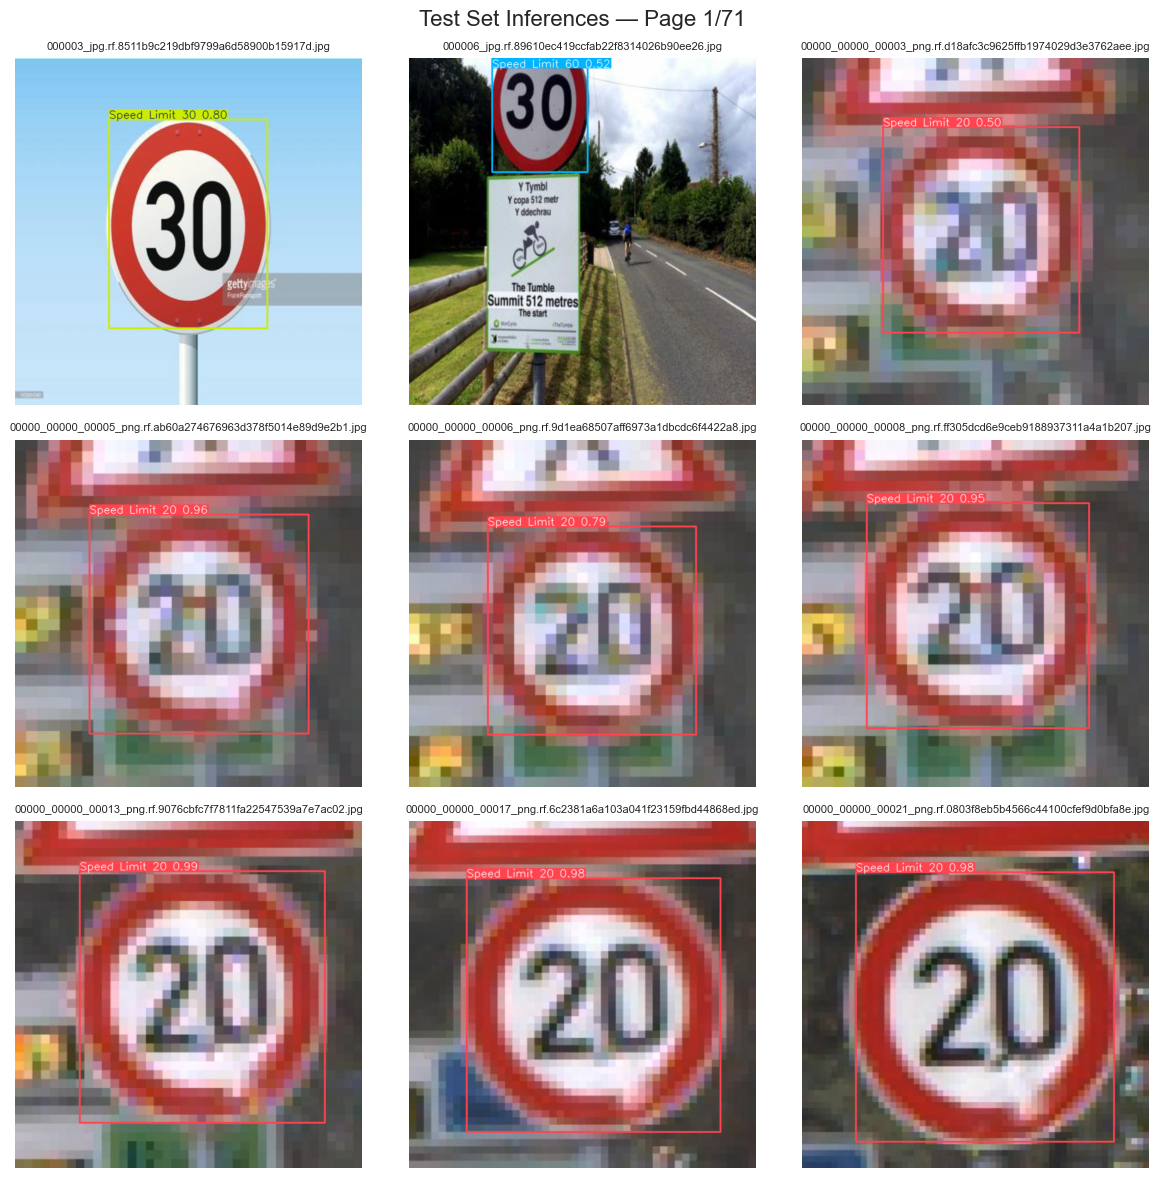

In [35]:
# Load the visualizer for the few-shot model
viz_few_shot = TestSetVisualizer(Valid_model)

# Show the first page of predictions
viz_few_shot.show_page(0, conf=0.5)



0: 640x640 2 Green Lights, 101.9ms
Speed: 2.8ms preprocess, 101.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 Green Lights, 91.6ms
Speed: 2.7ms preprocess, 91.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Green Light, 87.9ms
Speed: 3.8ms preprocess, 87.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 88.9ms
Speed: 4.2ms preprocess, 88.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Green Light, 90.2ms
Speed: 2.9ms preprocess, 90.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Green Light, 141.3ms
Speed: 5.3ms preprocess, 141.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 95.9ms
Speed: 3.5ms preprocess, 95.9ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 91.3ms
Speed: 3.7ms preprocess, 91.3ms infer

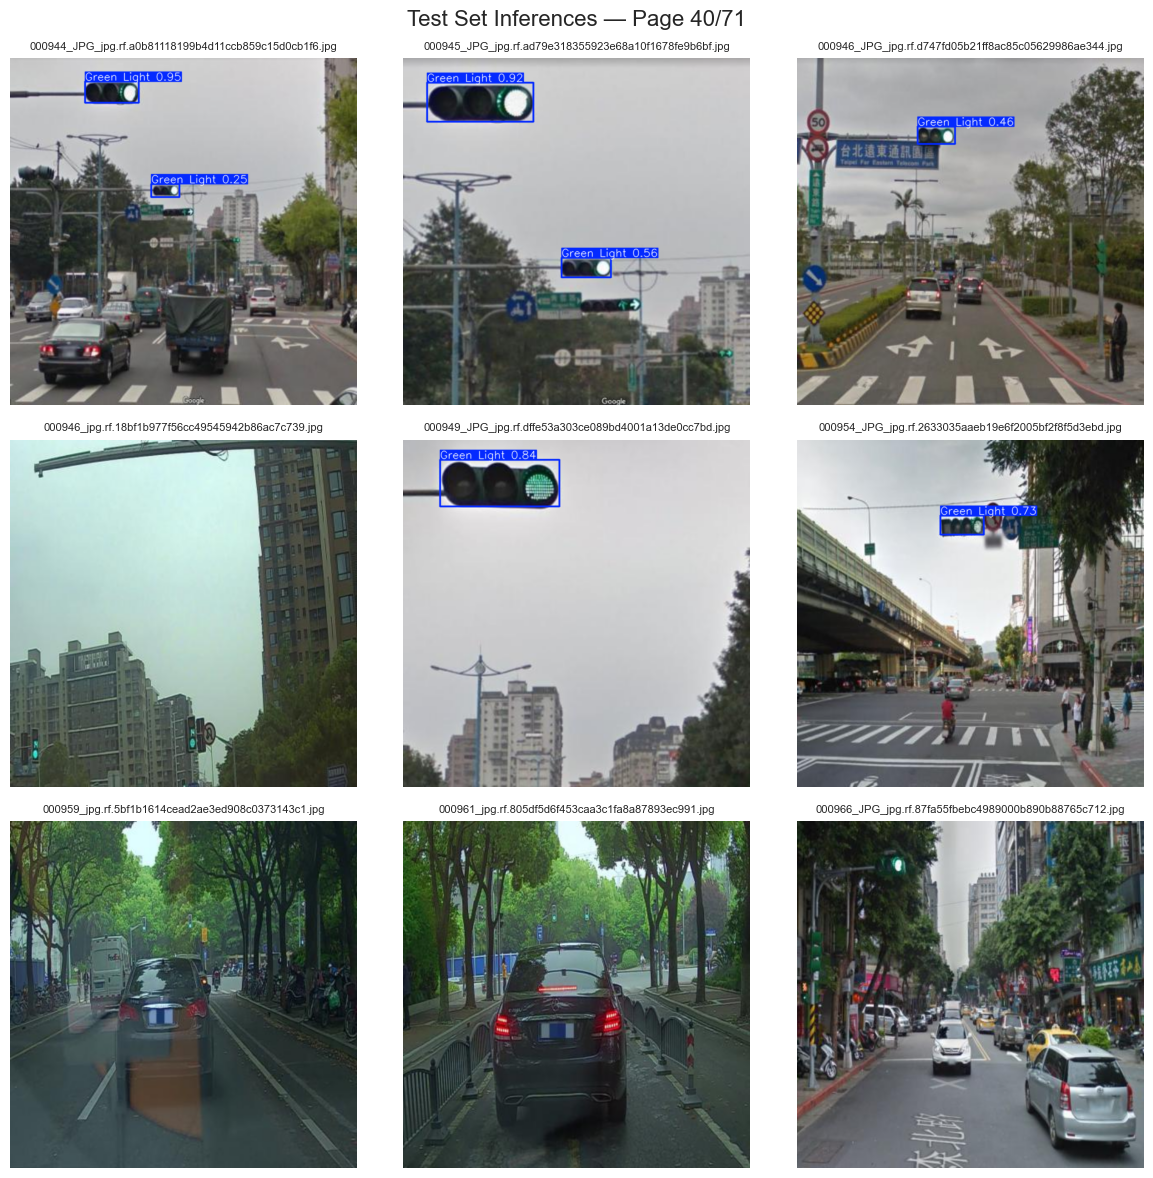

In [ ]:
# Visualize the differente batches of predictions
viz_few_shot.goto(39, conf=0.25)  


A few comments on observations made during the visual inspection;
- The models tends to miss out on those images that are extremely blurry, for which a human would also have trouble recognizing. It would be very interesting to compare the performance of the model against Human Level. 
- Model performs poorly for `Speed limit 30` on images that could be considered "easy", and often confuses it with `Speed Limit 20`, which is far more confidence in its own class predictions. This is likely due to the training signal that `Speed Limit 30` received (probably poor). 
- Different lighting does not seem to affect the performance, yet angles do have an impact, as the model often fails to recognise traffic signs from odd angles. 
- For traffic lights, the model performs better on those with an "empty background" (blue sky). When there is a less contrastive background (perhaps because of trees or buildings), it often fails to recognise them. 
